In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


## 🎬 Movie Recommendation System — A Content-Based Approach

This notebook presents a complete pipeline for building a content-based movie recommendation system using real-world data. The goal is to suggest movies that are similar in genre, cast, director, and storyline.

Here are the main steps covered:

- **Importing Libraries**: Setting up the tools required for data processing and modeling  
- **Data Exploration**: Reviewing the dataset structure and identifying key features  
- **Data Cleaning**: Handling missing values and preparing the data for analysis  
- **Data Analysis**: Visualizing patterns in genres, ratings, durations, and more  
- **Data Transformation**: Combining descriptive features and converting them into numerical vectors using TF-IDF  
- **Recommendation System**: Computing similarity scores and generating movie suggestions based on content features

By the end of this notebook, we build a system that recommends movies based on their content .

Let’s get started!

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

## Data Exploration

In [3]:
Movies_data=pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

In [4]:
Movies_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
Movies_data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [6]:
Movies_data.shape

(8807, 12)

In [7]:
Movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [8]:
Movies_data.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


## Data Cleaning

#### 1) Missing Values

In [9]:
Movies_data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [10]:
# 1) Drop show_id
Movies_data.drop(columns=["show_id"], inplace=True)

In [11]:
# 2) Fill 'type' with mode (most common value)
Movies_data['type'].fillna(Movies_data['type'].mode()[0], inplace=True)

# 3) Fill 'director' and 'cast' with 'Unknown'
Movies_data['director'].fillna("Unknown", inplace=True)
Movies_data['cast'].fillna("Unknown", inplace=True)

# 4) Fill 'country' with 'Unknown' or group by region later
Movies_data['country'].fillna("Unknown", inplace=True)

In [12]:
# 5) Handle 'date_added'
Movies_data['date_added'] = pd.to_datetime(Movies_data['date_added'], errors='coerce')
Movies_data['year_added'] = Movies_data['date_added'].dt.year
Movies_data['month_added'] = Movies_data['date_added'].dt.month
Movies_data['year_added'].fillna(Movies_data['year_added'].median(), inplace=True)
Movies_data['month_added'].fillna(Movies_data['month_added'].mode()[0], inplace=True)

In [13]:
# 6) Drop show_id
Movies_data.drop(columns=["date_added"], inplace=True)

In [14]:
Movies_data.columns

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description', 'year_added',
       'month_added'],
      dtype='object')

In [15]:
# 7) Fill 'rating' with 'Unrated'
Movies_data['rating'].fillna("Unrated", inplace=True)

# 8) Handle 'duration'
Movies_data['duration'].fillna("Unknown", inplace=True)
Movies_data['duration_mins'] = Movies_data['duration'].str.extract(r'(\d+)').astype(float)
Movies_data['duration_mins'].fillna(Movies_data['duration_mins'].median(), inplace=True)


# 9) Fill 'description' with empty string
Movies_data['description'].fillna("", inplace=True)

In [16]:
Movies_data.isnull().sum()

type             0
title            0
director         0
cast             0
country          0
release_year     0
rating           0
duration         0
listed_in        0
description      0
year_added       0
month_added      0
duration_mins    0
dtype: int64

#### 2) Duplicates

In [17]:
Movies_data.duplicated().sum()

0

## Data Analysis

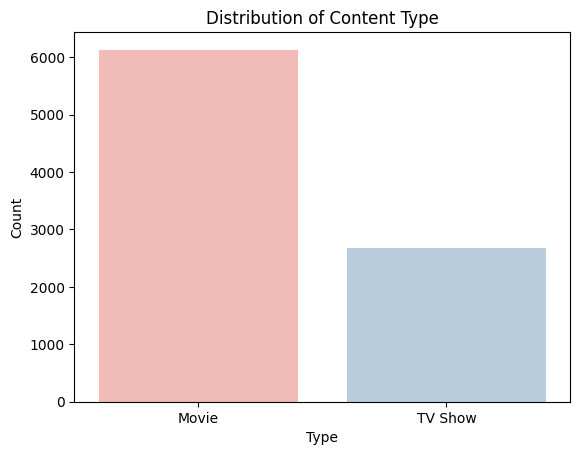

In [18]:
sns.set_palette("Pastel1")
sns.countplot(data=Movies_data, x='type')
plt.title('Distribution of Content Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

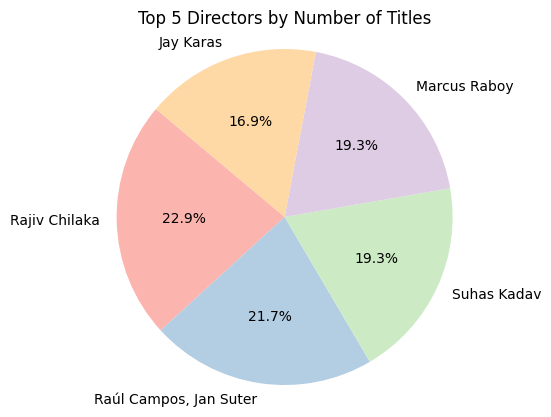

In [19]:
top_5_directors = Movies_data['director'].value_counts().drop('Unknown').head(5)
sns.set_palette("Pastel1")
plt.pie(top_5_directors.values, labels=top_5_directors.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Directors by Number of Titles')
plt.axis('equal') 
plt.show()

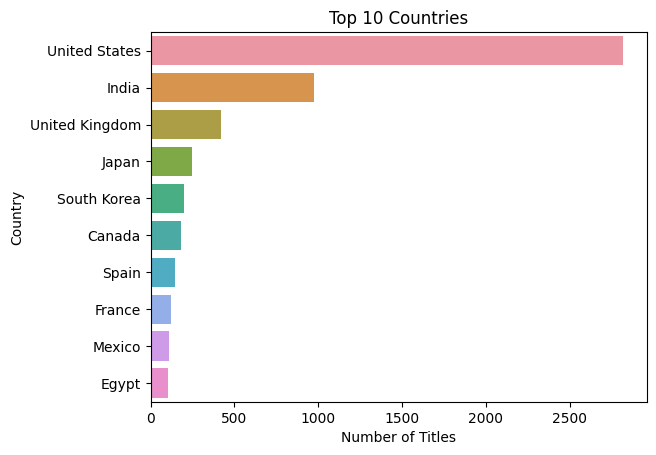

In [20]:
top_countries = Movies_data['country'].value_counts().drop('Unknown').head(10)
sns.set_palette("Pastel1")
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

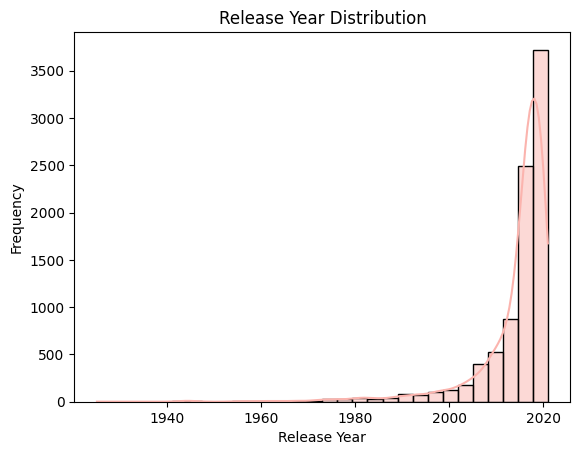

In [21]:
sns.histplot(Movies_data['release_year'], bins=30, kde=True)
plt.title('Release Year Distribution')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()

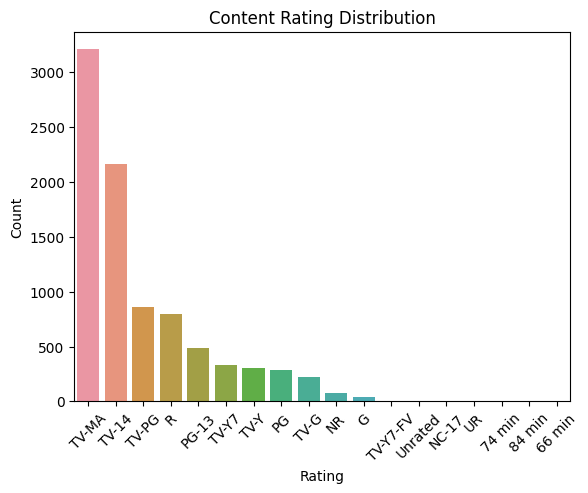

In [22]:
sns.countplot(data=Movies_data, x='rating', order=Movies_data['rating'].value_counts().index)
plt.title('Content Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Data Transformation

In [23]:
selected_cols = ['listed_in', 'description', 'cast', 'director', 'country', 'rating', 'duration_mins']
for col in selected_cols:
    Movies_data[col] = Movies_data[col].fillna('')

In [24]:
# Convert to bins: short (<60), medium (60–120), long (>120)
def bin_duration(mins):
    try:
        mins = float(mins)
        if mins < 60:
            return 'short'
        elif mins <= 120:
            return 'medium'
        else:
            return 'long'
    except:
        return 'unknown'

Movies_data['duration_bin'] = Movies_data['duration_mins'].apply(bin_duration)

In [25]:
Movies_data['combined_features'] = (
    Movies_data['listed_in'] + ' ' +
    Movies_data['description'] + ' ' +
    Movies_data['cast'] + ' ' +
    Movies_data['director'] + ' ' +
    Movies_data['country'] + ' ' +
    Movies_data['rating'] + ' ' +
    Movies_data['duration_bin']
)

In [26]:
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(Movies_data['combined_features'])

In [27]:
similarity = cosine_similarity(feature_vectors)

In [28]:
print(similarity)

[[1.         0.0068633  0.02244474 ... 0.01643689 0.02612296 0.0311078 ]
 [0.0068633  1.         0.0181148  ... 0.00102132 0.         0.00481813]
 [0.02244474 0.0181148  1.         ... 0.00557799 0.01032147 0.0333031 ]
 ...
 [0.01643689 0.00102132 0.00557799 ... 1.         0.06097384 0.00653445]
 [0.02612296 0.         0.01032147 ... 0.06097384 1.         0.01087696]
 [0.0311078  0.00481813 0.0333031  ... 0.00653445 0.01087696 1.        ]]


## Recommendation System

In [29]:
# 1) Create dropdown from available titles
movie_dropdown = widgets.Dropdown(
    options=sorted(Movies_data['title'].unique()),
    description='🎬 Select Movie:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

display(movie_dropdown)

# Access selected value
movie_name = movie_dropdown.value

# Step 2) Fuzzy match to closest title
list_of_titles = Movies_data['title'].tolist()
close_matches = difflib.get_close_matches(movie_name, list_of_titles)

Dropdown(description='🎬 Select Movie:', layout=Layout(width='50%'), options=('#Alive', '#AnneFrank - Parallel …

In [30]:
if not close_matches:
    print("No close match found. Please check the spelling or try another title.")
else:
    best_match = close_matches[0]
    index_of_movie = Movies_data[Movies_data['title'] == best_match].index[0]
    # Step 3) Get similarity scores
    similarity_scores = list(enumerate(similarity[index_of_movie]))
    sorted_similar_movies = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # Step 4) Display top 10 recommendations
    print(f"\n Because you liked '{best_match}', you might also enjoy:\n")
    for i, (index, score) in enumerate(sorted_similar_movies[1:11], 1):
        print(f"{i}. {Movies_data.iloc[index]['title']}")


 Because you liked '#Alive', you might also enjoy:

1. Stranger
2. Bad Guys
3. Reply 1994
4. Berlin Syndrome
5. Secret Affair
6. Reply 1988
7. Memoir of a Murderer
8. Jumping Girl
9. Sisyphus
10. Record of Youth


### Evaluation of the Recommendation System

In [31]:
# Simulated ground truth: movies each user liked
user_likes = {
    "User1": ["Inception", "Interstellar", "The Matrix", "Tenet"],
    "User2": ["Titanic", "The Notebook", "La La Land"]
}

In [32]:
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum([1 for movie in recommended_k if movie in relevant_set])
    return hits / k

def recall_at_k(recommended, relevant, k):
    relevant_set = set(relevant)
    hits = sum([1 for movie in recommended[:k] if movie in relevant_set])
    return hits / len(relevant_set) if relevant_set else 0

In [33]:
recommended_movies = ["Inception", "Tenet", "The Matrix", "Avatar", "Interstellar"]
relevant_movies = user_likes["User1"]

print("Precision@5:", precision_at_k(recommended_movies, relevant_movies, 5))
print("Recall@5:", recall_at_k(recommended_movies, relevant_movies, 5))

Precision@5: 0.8
Recall@5: 1.0


###  Evaluation Results: Precision@5 and Recall@5

After generating recommendations, we evaluated the system using two key metrics:

- **Precision@5 = 0.8**  
  This means that 80% of the top 5 recommended movies were actually relevant (liked by the user).  
  → High precision indicates that the system is accurate in its top suggestions.

- **Recall@5 = 1.0**  
  This means that the system successfully retrieved all relevant movies within the top 5 recommendations.  
  → A recall of 1.0 shows excellent coverage — no relevant items were missed.

These results suggest that the content-based recommendation system is performing very well for this user. You can repeat this evaluation across multiple users or titles to assess overall performance.